In [ ]:
https://www.kaggle.com/code/kashyapgohil/pneumonia-detection-using-cnn/notebook

https://www.kaggle.com/code/amahbubul85/cnn-classifier-using-transfer-learning/notebook

In [1]:
# Install scikeras if not already installed
!pip install scikeras
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.7.2

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 41.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from scikeras.wrappers import KerasClassifier # Se requiere scikeras para usar Keras con GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator # permite aumentar imágenes en tiempo real mientras el modelo se está entrenando.
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
from keras.callbacks import ReduceLROnPlateau # permite reducir automáticamente la tasa de aprendizaje (learning rate) cuando el entrenamiento del modelo se estanca.
import cv2 # Librería de OpenCV proporciona las funciones principales para la visión artificial, permitiendo realizar operaciones de procesamiento de imágenes y video en Python.
from google.colab.patches import cv2_imshow # Para mostrar imágenes en Colab
import pickle
import os



In [4]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def cargar_datasets(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label) # Construir la ruta de archivo completa y correcta
        class_num = labels.index(label) # Encuentra la posición numérica en "labels" y la almacena en "class_num". "Pneumonia = 0". "Normal =1"
        for img in os.listdir(path): # Toma cada imagen en el directorio
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is not None: # Verificar si la imagen fue cargada correctamente
                  resized_arr = cv2.resize(img_arr, (img_size, img_size))
                  data.append([resized_arr, class_num])
                else:
                    print(f"Warning: Could not read image {os.path.join(path, img)}")
            except Exception as e:
                print(e)
    return np.array(data, dtype=object) # Usar dtype=object si los elementos tienen formas diferentes, caso contrario arroja error.

In [5]:
train = cargar_datasets('/content/drive/MyDrive/Datasets/chest_xray/train')

In [6]:
test = cargar_datasets('/content/drive/MyDrive/Datasets/chest_xray/test')

In [7]:
val  = cargar_datasets('/content/drive/MyDrive/Datasets/chest_xray/val')

In [8]:
print(type(val), type(train), type(test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [9]:
print(train)

[[array([[39, 38, 51, ..., 35, 35, 34],
         [43, 37, 43, ..., 35, 35, 34],
         [41, 36, 39, ..., 35, 35, 34],
         ...,
         [41, 47, 51, ..., 45, 49, 50],
         [41, 47, 50, ..., 43, 44, 50],
         [40, 49, 53, ..., 41, 46, 47]], dtype=uint8) 0]
 [array([[ 21,  12,   1, ..., 106,  36,  61],
         [ 11,   0,  10, ...,  48,  64, 101],
         [ 21,  24,  32, ...,  18,  41,  37],
         ...,
         [ 13,   5,   2, ...,   8,   9,   6],
         [  8,   5,   0, ...,   8,   9,   0],
         [  6,   4,   0, ...,   9,   9,   9]], dtype=uint8) 0]
 [array([[  2, 255,   8, ...,   0,   0,   0],
         [  2, 255,   8, ...,   0,   0,   0],
         [  2, 251,   7, ...,   0,   0,   0],
         ...,
         [  0,   1,  13, ...,   0,   0,   0],
         [  0,   2,  13, ...,   0,   0,   0],
         [  0,   2,  13, ...,   0,   0,   0]], dtype=uint8) 0]
 ...
 [array([[ 36,  20,  14, ...,  22,   0,  14],
         [ 49,  22,  13, ...,  20,   8,  11],
         [ 57,  33

In [10]:
print (train[0])

[array([[39, 38, 51, ..., 35, 35, 34],
        [43, 37, 43, ..., 35, 35, 34],
        [41, 36, 39, ..., 35, 35, 34],
        ...,
        [41, 47, 51, ..., 45, 49, 50],
        [41, 47, 50, ..., 43, 44, 50],
        [40, 49, 53, ..., 41, 46, 47]], dtype=uint8) 0]


In [11]:
print (train[0][0])

[[39 38 51 ... 35 35 34]
 [43 37 43 ... 35 35 34]
 [41 36 39 ... 35 35 34]
 ...
 [41 47 51 ... 45 49 50]
 [41 47 50 ... 43 44 50]
 [40 49 53 ... 41 46 47]]


In [12]:
print (train[0][1])

0


### Verificar el balance de los datasets
  - Revisar cuantos datos de entrenamiento y de prueba de cada clase existen.

<Axes: ylabel='count'>

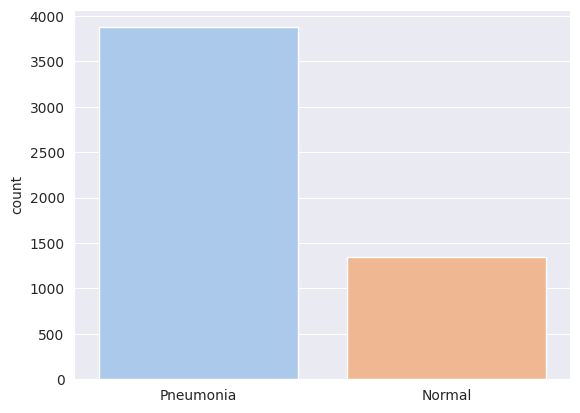

In [13]:
check_dataset_balance_train = []
for i in train:
    if(i[1] == 1):
        check_dataset_balance_train.append("Normal")
    else:
        check_dataset_balance_train.append("Pneumonia")

sns.set_style('darkgrid')
sns.set_palette('pastel')
sns.countplot(orient='v', x=check_dataset_balance_train, hue= check_dataset_balance_train )


<Axes: ylabel='count'>

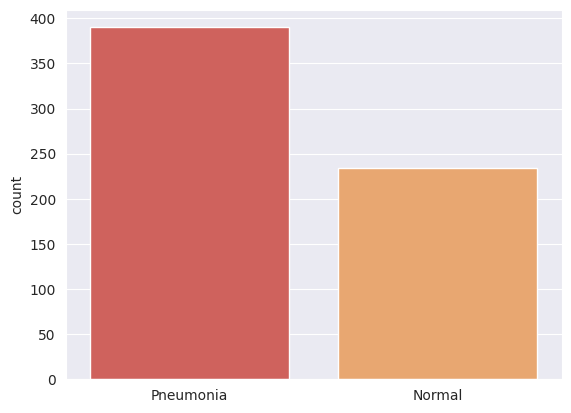

In [14]:
check_dataset_balance_test = []
for i in test:
    if(i[1] == 1):
        check_dataset_balance_test.append("Normal")
    else:
        check_dataset_balance_test.append("Pneumonia")
sns.set_style('darkgrid')
sns.set_palette('Spectral')
sns.countplot(orient='v', x=check_dataset_balance_test, hue= check_dataset_balance_test)

array([[39, 38, 51, ..., 35, 35, 34],
       [43, 37, 43, ..., 35, 35, 34],
       [41, 36, 39, ..., 35, 35, 34],
       ...,
       [41, 47, 51, ..., 45, 49, 50],
       [41, 47, 50, ..., 43, 44, 50],
       [40, 49, 53, ..., 41, 46, 47]], dtype=uint8)
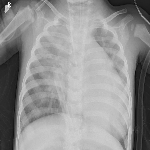

In [15]:
train[0][0]

Text(0.5, 1.0, 'NORMAL')

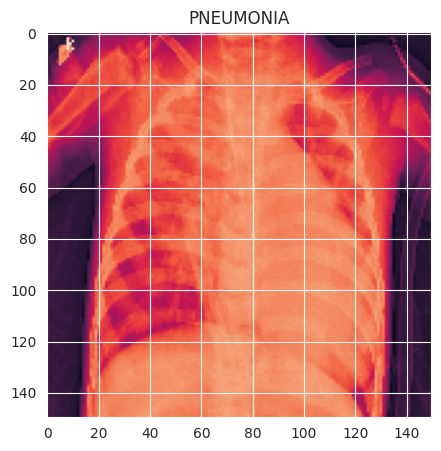

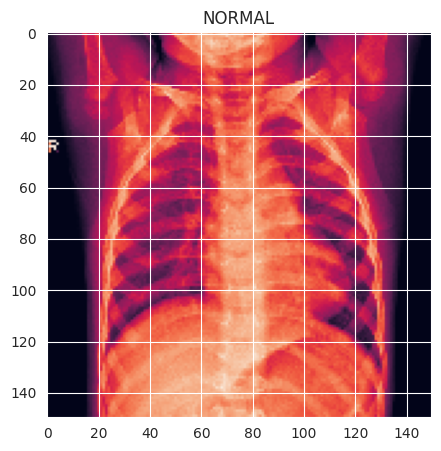

In [16]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0])
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

Text(0.5, 1.0, 'NORMAL')

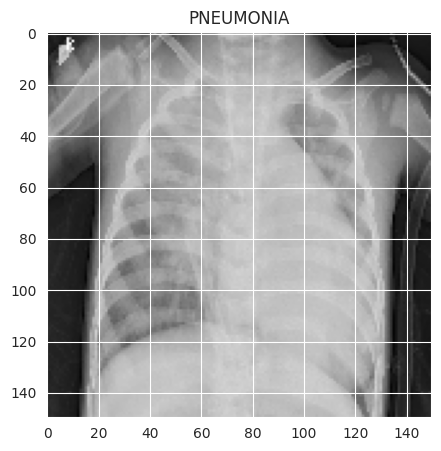

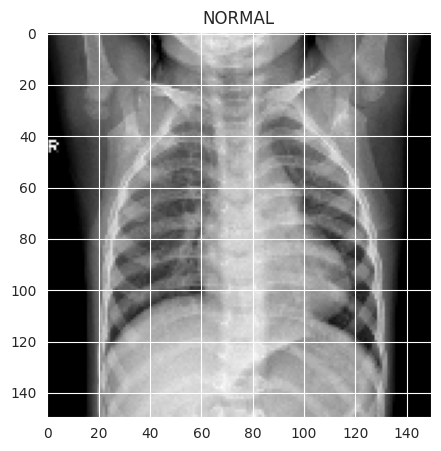

In [17]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0],cmap="gray")
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0],cmap="gray")
plt.title(labels[train[-1][1]])

In [18]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

### Normalización de los datos.

#### Realicemos una normalización de la escala de grises para reducir los efectos de la diferencia de iluminación. Ademas la CNN converge mas rápido con datos entre 0 y 1 que con datos entre 0 y 255.

Esta es una práctica recomendada.

In [19]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [20]:
x_train.ndim #dimension del array (3)

3

### Preparación de los datos en el formato requerido por CNN

El arreglo x_train es reconfigurado a una nueva forma. La nueva forma es un arreglo de cuatro dimensiones. La primera dimensión es inferida automáticamente ( se expresa con el parámetro -1). La segunda y tercera dimensión corresponden al tamaño de la imagen. La cuarta dimensión es el canal de color.



In [21]:
# Reconfigurar los datos para CNN
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [22]:
x_train.ndim #array dimensionado (4)

4

### Desarrollo y entrenamiento del modelo

---

Despues de correr GridSearchCV se encontraron los mejores hiperparámetros:

  - {'batch_size': 64,
 'epochs': 5,
 'model__dropout_rate': 0.3,
 'model__filters_per_layer': 16,
 'model__num_conv_layers': 3,
 'model__optimizer': 'sgd'}

 Sin embargo, el modelo sigue mostrando "overfitting", causado por el desbalance de clases.

 ---

Para solucionar el desbalance de clases aplicaremos la técnica SMOTE (Synthetic Minority Over-sampling Technique), diseñada para, precisamente, mitigar el problema del overfitting causado por el desbalance de clases.

In [23]:
from imblearn.over_sampling import SMOTE

# Redimensionar x_train para SMOTE (Para estar seguros)
n_samples = x_train.shape[0]
x_reshaped = x_train.reshape(n_samples, -1)

# Inicializar SMOTE
sampler = SMOTE(random_state=42)

# Aplicar SMOTE al set de datos de entrenamiento para crear un dataset balanceado.
x_resampled, y_resampled = sampler.fit_resample(x_reshaped, y_train)

# Redimensionar x_resampled al formato 4D requerido por CNN.

x_resampled = x_resampled.reshape(-1, img_size, img_size, 1)

# Luego, cuando se llame al "model.fit()" debemos usar `x_resampled` y `y_resampled` .`
#  `history = model.fit(x_resampled, y_resampled, ...)`

In [24]:
model = Sequential()
model.add(Input(shape=(150,150,1)))
# Primer Conv layer
#model.add(Conv2D(16 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# Segunda Conv Layer
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# Tercer Conv Layer
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# Cuarta Cov Layer
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
# Quinta conv Layer
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       102,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 140,609 (549.25 KB)

 Trainable params: 140,289 (548.00 KB)

 Non-trainable params: 320 (1.25 KB)

In [25]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [26]:
history = model.fit(x_resampled, y_resampled, batch_size=64, epochs=15, validation_data=(x_val, y_val), callbacks=[learning_rate_reduction])

Epoch 1/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 605s 5s/step - accuracy: 0.8556 - loss: 0.3676 - val_accuracy: 0.5000 - val_loss: 1.2370 - learning_rate: 0.0010
Epoch 2/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 555s 4s/step - accuracy: 0.9704 - loss: 0.0823 - val_accuracy: 0.5000 - val_loss: 1.8209 - learning_rate: 0.0010
Epoch 3/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9787 - loss: 0.0598
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
122/122 ━━━━━━━━━━━━━━━━━━━━ 582s 4s/step - accuracy: 0.9787 - loss: 0.0598 - val_accuracy: 0.5000 - val_loss: 2.3004 - learning_rate: 0.0010
Epoch 4/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 504s 4s/step - accuracy: 0.9848 - loss: 0.0441 - val_accuracy: 0.5000 - val_loss: 1.6599 - learning_rate: 3.0000e-04
Epoch 5/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 540s 4s/step - accuracy: 0.9888 - loss: 0.0358 - val_accuracy: 0.5625 - val_loss: 0.9773 - learning_rate: 3.0000e-04
Epoch 6/15
122/122 ━━━━━━━━━━━━━━━━━━━━ 476s 4s/step - accuracy: 0.9878 - los

In [27]:
print("Pérdida del modelo es : " , model.evaluate(x_test,y_test)[0])
print("Precisión del modelo es : " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 586ms/step - accuracy: 0.9247 - loss: 0.3058
Pérdida del modelo es :  1.0868054628372192
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 568ms/step - accuracy: 0.9247 - loss: 0.3058
Precisión del modelo es :  74.03846383094788 %


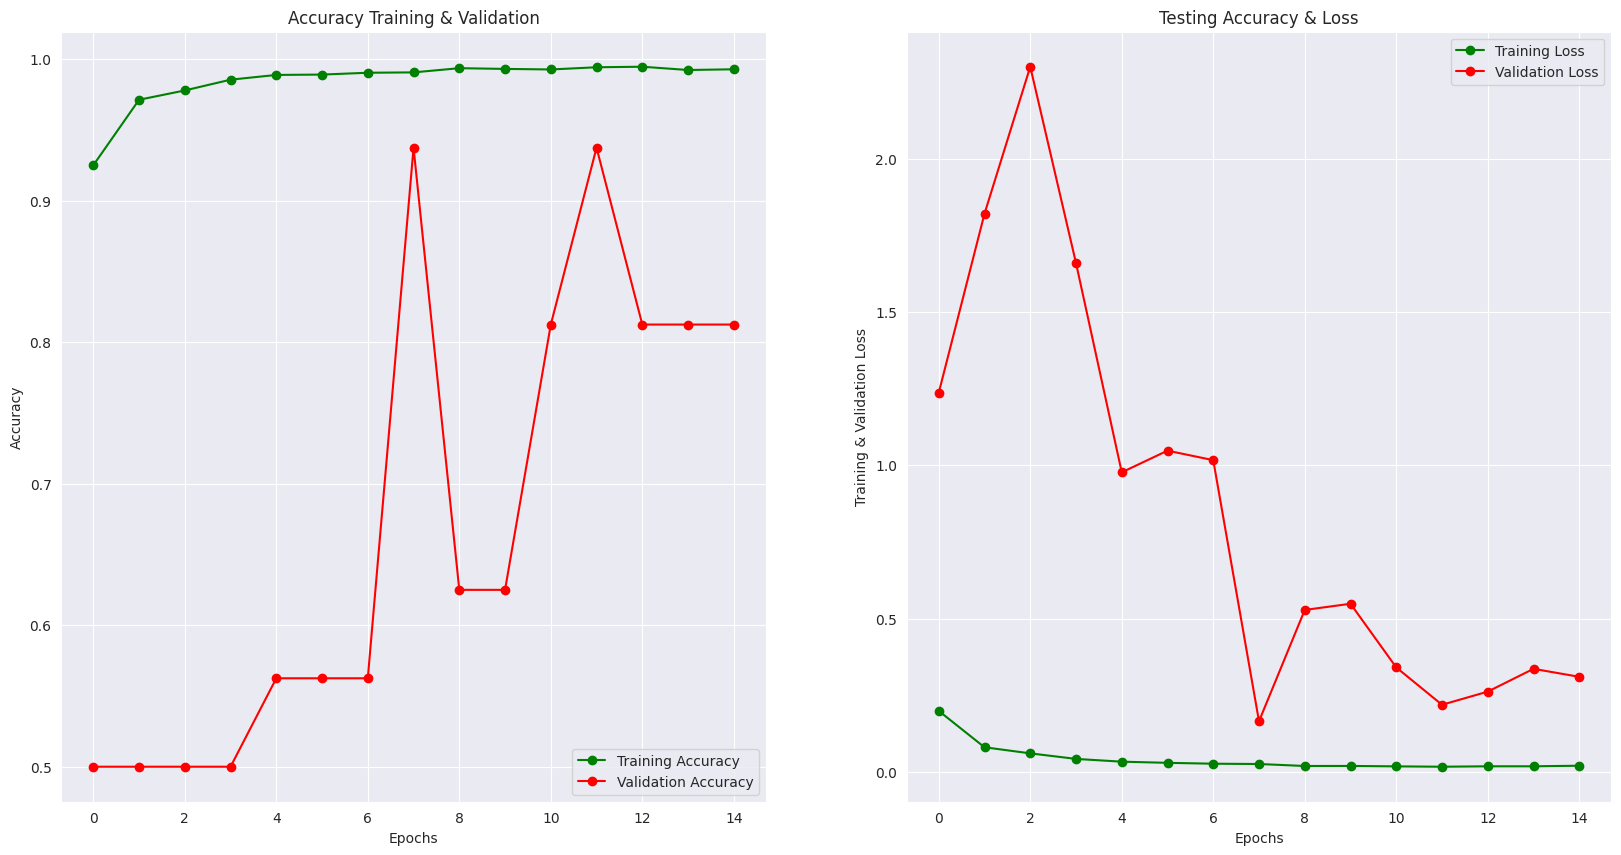

In [28]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Accuracy Training & Validation')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

SMOTE contribuyó a mejorar sustancialmente el overfitting, balanceando las clases, pero los graficos de accuracy y loss, aun no convergen.

---

In [29]:
import pickle
with open('model_SMOTE.pkl', 'wb') as file:
    pickle.dump(model, file)

Revisemos otros indicadores (métricas) que nos orienten en la manera de obtener mejores resultados.

In [45]:
predictions = model.predict(x_test) # Valores en formato floating point
predicciones = (predictions > 0.5).astype(int).reshape(1,-1)[0] # Valores enteros 0 y 1
print(f' 10 Valores con threshold > 0.5 \n {predicciones[:10]} \n\n', f'10 Valores sin aplicar threshold \n {predictions[:10]}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step
 10 Valores con threshold > 0.5 
 [0 0 0 0 0 0 0 0 0 0] 

 10 Valores sin aplicar threshold 
 [[2.67382828e-04]
 [5.34467772e-03]
 [2.16575645e-04]
 [7.57830276e-06]
 [3.16516752e-03]
 [1.01047524e-04]
 [1.66508983e-07]
 [2.46507498e-05]
 [2.25579388e-05]
 [1.92574789e-05]]


In [31]:
print(classification_report(y_test, predicciones, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.71      1.00      0.83       390
   Normal (Class 1)       1.00      0.31      0.47       234

           accuracy                           0.74       624
          macro avg       0.85      0.65      0.65       624
       weighted avg       0.82      0.74      0.69       624



In [32]:
cm = confusion_matrix(y_test,predicciones)
cm

array([[390,   0],
       [162,  72]])

De la visualización de la matriz de confusión podemos decir que hay todavia demasiados Falso Negativos y pocos Verdadero Negativos.

Para corregir un modelo con muchos falsos positivos (FP) y pocos verdaderos negativos (VN), debemos enfocarnos en aumentar la ***especificidad*** (**capacidad del modelo para identificar correctamente los casos negativos**) y reducir la tasa de error tipo I. Las estrategias clave incluyen ***ajustar el umbral de clasificación*** y evaluar métricas adecuadas.

  - Ajuste del Umbral de Clasificación
    - La forma más directa de abordar este problema es modificando el umbral de decisión del modelo.
      - Entender el umbral: La mayoría de los modelos de clasificación binaria predicen una probabilidad (entre 0 y 1) y usan un umbral por defecto (comúnmente 0.5) para decidir la clase final.
      - Acción: Para reducir los falso positivos (y aumentar los verdadero negativos), se necesita aumentar el umbral de clasificación. ***Al requerir una probabilidad más alta para clasificar algo como positivo, el modelo se vuelve más estricto, reduciendo los FP, aunque esto podría aumentar ligeramente los falsos negativos (FN).***
      - Herramientas: Puedes usar herramientas como la curva ***ROC (Receiver Operating Characteristic)*** o la curva ***Precisión-Recall*** para visualizar el trade-off entre las diferentes métricas en distintos umbrales y elegir el punto óptimo para solucionar el problema específico.

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision1=precision_score(y_test,predicciones)
recall1=recall_score(y_test,predicciones)
f1score1=f1_score(y_test,predicciones)
print(f"Precision: {precision1}")
print(f"Recall: {recall1}")
print(f"F1 Score: {f1score1}")

Precision: 1.0
Recall: 0.3076923076923077
F1 Score: 0.47058823529411764


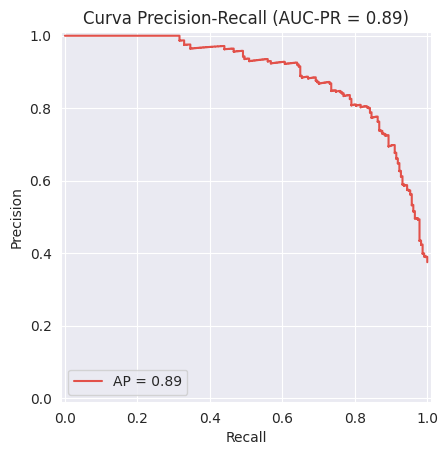

El umbral óptimo (F1-score máximo) es: 0.0039


In [34]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, auc

# 1. Calcular los valores de precisión y recuperación para todos los umbrales
precision, recall, thresholds = precision_recall_curve(y_test, predictions)

# 2. Graficar la curva PR
pr_auc = auc(recall, precision)
display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=pr_auc)
display.plot()
plt.title(f'Curva Precision-Recall (AUC-PR = {pr_auc:.2f})')
plt.show()

# 3. Ajustar el umbral: Encontrar el umbral óptimo (ej. maximizando F1-score)
f1_scores = 2 * (precision * recall) / (precision + recall)
# Reemplazar NaN o inf con 0 para evitar errores
f1_scores = np.nan_to_num(f1_scores)
optimal_threshold_index = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_threshold_index]
print(f"El umbral óptimo (F1-score máximo) es: {optimal_threshold:.4f}")

# 4. Usar el nuevo umbral para hacer predicciones
y_pred_adjusted = (predictions >= optimal_threshold).astype(int)

# Ahora puedes evaluar y_pred_adjusted con otras métricas como la matriz de confusión.

In [35]:
cm1 = confusion_matrix(y_test,y_pred_adjusted)
cm1

array([[341,  49],
       [ 37, 197]])

In [36]:
f1_scores

array([0.54545455, 0.54609102, 0.54672897, 0.54736842, 0.54800937,
       0.54865182, 0.54929577, 0.54994125, 0.55058824, 0.55123675,
       0.55188679, 0.55253837, 0.55319149, 0.55384615, 0.55450237,
       0.55516014, 0.55581948, 0.55648038, 0.55714286, 0.55780691,
       0.55847255, 0.55913978, 0.55980861, 0.56047904, 0.56115108,
       0.55942377, 0.56009615, 0.56077016, 0.56144578, 0.56212304,
       0.56038647, 0.56106409, 0.56174334, 0.56242424, 0.5631068 ,
       0.56379101, 0.56447689, 0.56516443, 0.56585366, 0.56654457,
       0.56723716, 0.56793146, 0.56862745, 0.56932515, 0.56756757,
       0.56826568, 0.56896552, 0.56966708, 0.57037037, 0.5710754 ,
       0.57178218, 0.57249071, 0.57320099, 0.57391304, 0.57462687,
       0.57534247, 0.57605985, 0.57677903, 0.5775    , 0.57822278,
       0.57894737, 0.57967378, 0.58040201, 0.58113208, 0.58186398,
       0.58259773, 0.58333333, 0.5840708 , 0.58481013, 0.58555133,
       0.58629442, 0.58703939, 0.58778626, 0.58853503, 0.58928

In [44]:
y_pred_adjusted = (predictions >= optimal_threshold).astype(int)
y_pred_adjusted[:10]

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

CONCLUSION:

El valor del umbral óptimo encontrado con el análisis de la curva AUC-PR es excepcionalmente bajo, lo cual sugiere que el modelo está trabajando con datos altamente desbalanceados o que la clase positiva es muy rara.